# Econ 8400 Problem Set 1: Work Hours Choices with Static Labor Supply

## Haosi Shen, Spring 2025

# Model Setup
Suppose that individuals have the choice to work $h\in\{0,10,20,30,40\}$ hours per week. Preferences over these discrete alternatives may be described by a parametric utility function:
$$
u(c,h)=\gamma \cdot (\theta^{-1}c^{\theta} -\alpha h)+\epsilon_h
$$
where the state-specific errors $\epsilon_h$ follow a Type-I extreme value (Gumbel) distribution.  Consumption is given by the budget constraint 
$$
c = y+wh-T(wh)
$$
where $y$ is the non-labor income, $T(\cdot)$ is the tax system, and $w$ is the gross hourly wage rate generated by the following log-linear relationship
$$
\ln{w}=\mu_w + \epsilon_w
$$
where the unobserved component of wages $\epsilon_w \sim \mathcal{N}(0,\sigma_w)$.


In [3]:
# Housekeeping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm

np.random.seed(123)

# Simulation

Suppose that the parameter values are $\sigma_w = 0.55$, $\mu_w=1$, $\theta=0.3$, $\alpha=0.1$, $\gamma=2$, and that $Y\sim\text{Uniform}(10,100)$.

Suppose also that earnings below 80 per week are not taxed; any
earnings greater than 80 are taxed at the constant marginal tax rate $\tau=0.3$.  Non-labor income is not taxed.
$$T(wh)=\begin{cases}
    0\quad&\text{if }wh<80\\
    \tau\cdot(wh-80)\quad&\text{if }wh\geq80
\end{cases}$$
Define the utility with respect to each work hour choice:
$$U_h=\gamma \cdot (\theta^{-1}c(h)^{\theta} -\alpha h)+\epsilon_h$$

Under these assumptions, simulate a dataset of 1,000 observations.

In [5]:
#================================================================
## ======================== SETUP ===============================
#================================================================

# Parameters
sigma_w = 0.55
mu_w = 1
theta = 0.3
alpha = 0.1
gamma = 2
tau = 0.3
n_individuals = 1000
hours_options = [0, 10, 20, 30, 40]

# Non-labor income Y
Y = np.random.uniform(10, 100, n_individuals)

# Wages
eps_w = np.random.normal(0, sigma_w, n_individuals)
w = np.exp(mu_w + eps_w)


In [6]:
# Helper functions

# Progressive tax system
def compute_tax(earnings):
    return np.where(earnings < 80, 0, tau * (earnings - 80))

# Utility (without stochastic Gumbel shock)
def utility(c, h, theta, alpha, gamma):
    return gamma * ((1 / theta) * c**theta - alpha * h)


In [7]:
# Work hour choices

choices = []

for i in range(n_individuals):
    utilities = []
    for h in hours_options:
        earnings = w[i] * h
        tax = compute_tax(earnings)
        
        # back up consumption from budget constraint
        c = Y[i] + earnings - tax

        # compute realized utility for each hour choice
        eps_h = np.random.gumbel(0, 1)
        U_h = utility(c, h, theta, alpha, gamma) + eps_h
        utilities.append(U_h)
        
    # Hours chosen from the finite set to maximize utility
    choice = hours_options[np.argmax(utilities)]
    choices.append(choice)
    

In [8]:
data = pd.DataFrame({
    'NonLaborIncome': Y,
    'Wage': w,
    'HoursWorked': choices
})
data['Earnings'] = data['Wage'] * data['HoursWorked']
data['Tax'] = compute_tax(data['Earnings'])
data['Consumption'] = data['NonLaborIncome'] + data['Earnings'] - data['Tax']
data.to_csv('simulated_labor_supply.csv', index=False)
data.head()

,NonLaborIncome,Wage,HoursWorked,Earnings,Tax,Consumption
0,72.682227,2.703324,30,81.099713,0.329914,153.452026
1,35.752540,1.707270,10,17.072699,0.000000,52.825239
2,30.416631,4.487534,20,89.750680,2.925204,117.242107
3,59.618329,1.276378,30,38.291353,0.000000,97.909682
4,74.752207,2.011969,10,20.119691,0.000000,94.871898


### Plot the distribution of work hours in your simulated dataset. 

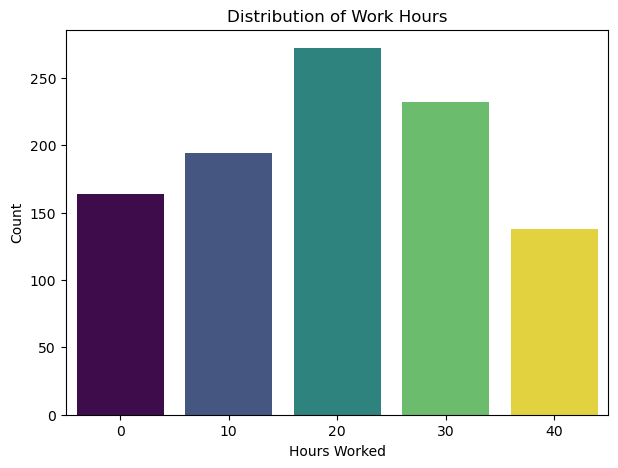

In [10]:
# Distribution of Work Hour Choices
plt.figure(figsize=(7, 5))
sns.countplot(x='HoursWorked', data=data, palette='viridis', hue='HoursWorked', legend=False)
plt.title('Distribution of Work Hours')
plt.xlabel('Hours Worked')
plt.ylabel('Count')
plt.savefig('work_hours_disn.png', dpi=300, bbox_inches='tight')
plt.show()

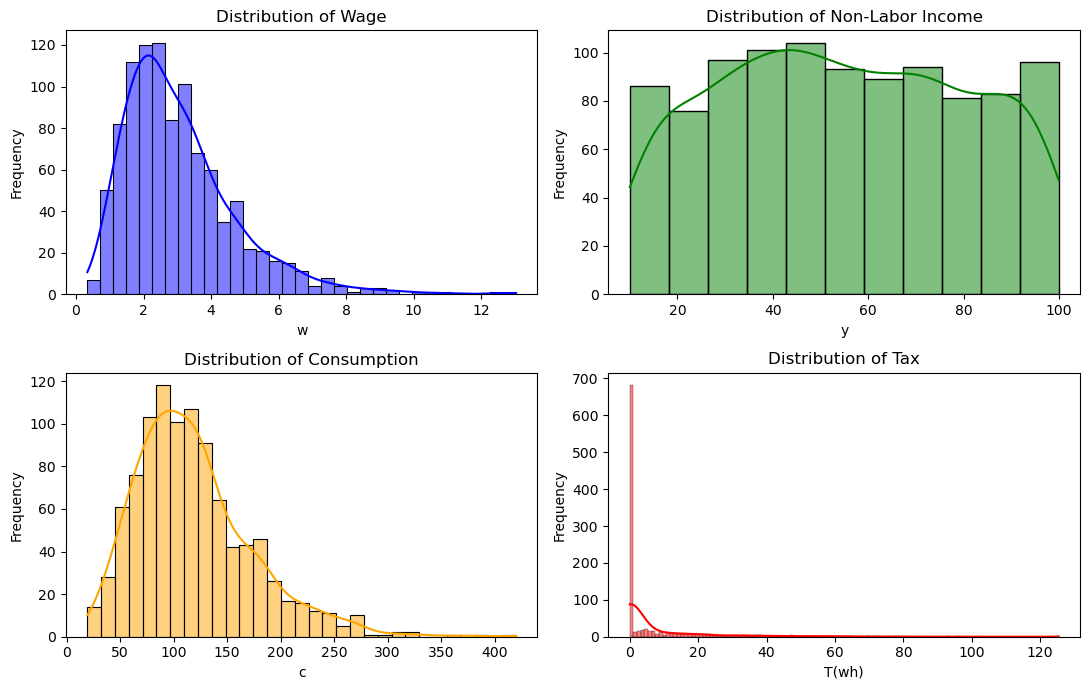

In [11]:

plt.figure(figsize=(11, 7))

# Distribution of Wage
plt.subplot(2, 2, 1)
sns.histplot(data['Wage'], kde=True, color='blue')
plt.title('Distribution of Wage')
plt.xlabel('w')
plt.ylabel('Frequency')

# Distribution of Non-Labor Income
plt.subplot(2, 2, 2)
sns.histplot(data['NonLaborIncome'], kde=True, color='green')
plt.title('Distribution of Non-Labor Income')
plt.xlabel('y')
plt.ylabel('Frequency')

# Distribution of Consumption
plt.subplot(2, 2, 3)
sns.histplot(data['Consumption'], kde=True, color='orange')
plt.title('Distribution of Consumption')
plt.xlabel('c')
plt.ylabel('Frequency')

# Distribution of Tax
plt.subplot(2, 2, 4)
sns.histplot(data['Tax'], kde=True, color='red')
plt.title('Distribution of Tax')
plt.xlabel('T(wh)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('q1_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


### Assess how the distribution of non-labor income and (offered) wages varies with work hours. 

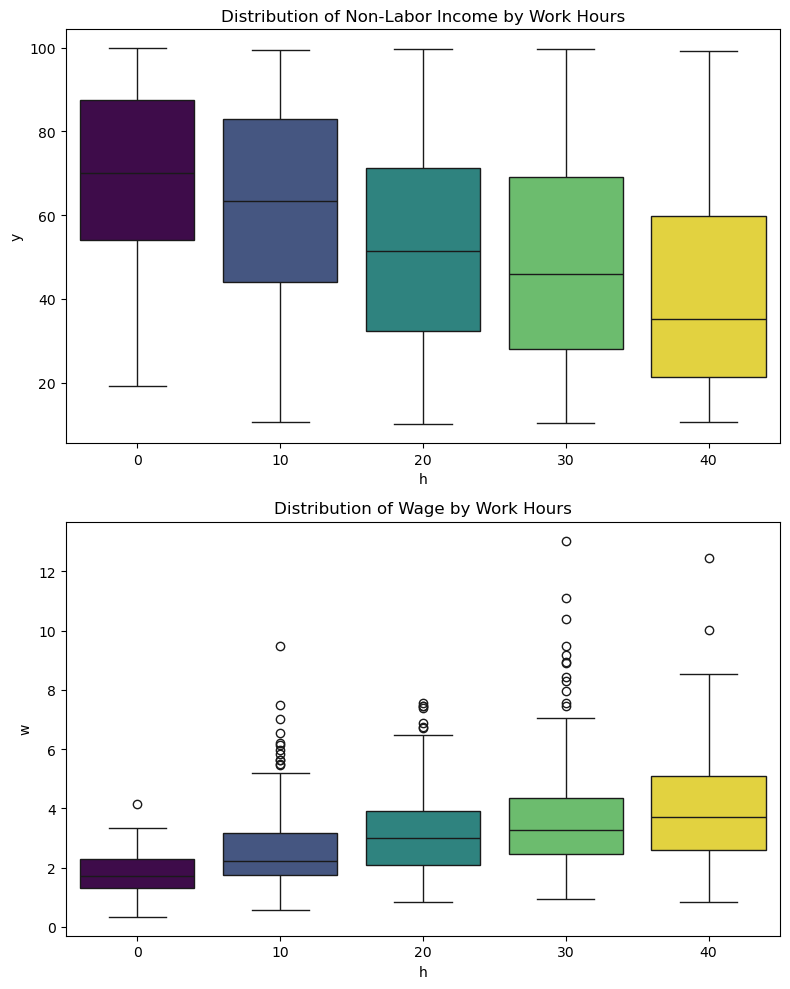

In [13]:
plt.figure(figsize=(8, 10))

# Distribution of Non-Labor Income by Work Hours
plt.subplot(2, 1, 1)
sns.boxplot(x='HoursWorked', y='NonLaborIncome', data=data, hue='HoursWorked', palette='viridis', legend=False)
plt.title('Distribution of Non-Labor Income by Work Hours')
plt.xlabel('h')
plt.ylabel('y')

# Distribution of Wage by Work Hours
plt.subplot(2, 1, 2)
sns.boxplot(x='HoursWorked', y='Wage', data=data, hue='HoursWorked', palette='viridis', legend=False)
plt.title('Distribution of Wage by Work Hours')
plt.xlabel('h')
plt.ylabel('w')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('income_wage_by_hours.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
summary_stats = data.groupby('HoursWorked')[['NonLaborIncome', 'Wage']].agg(['mean', 'median', 'std'])
print(summary_stats)

            NonLaborIncome                            Wage                    
                      mean     median        std      mean    median       std
HoursWorked                                                                   
0                69.287297  69.982533  20.341741  1.791325  1.703937  0.671854
10               62.714483  63.500455  24.222701  2.616484  2.230810  1.421127
20               52.643284  51.369434  24.469217  3.141789  3.016635  1.351726
30               48.612248  45.857918  25.447122  3.686194  3.285297  1.872235
40               42.150954  35.139643  25.099111  3.995343  3.719198  1.913297


# MLE

The model's log-likelihood function is
\begin{align*}
\ln{L(\theta)}&=\sum_{i=1}^{N}\ln{L_i} \\
&=\sum_{i=1}^{N}\bigg[\ln{\Big(\int_{-\infty}^{\infty}Pr(h_i\mid w_i,y_i)\cdot f_w(w_i) dw_i  \Big)}\bigg] \\
&= \sum_{i=1}^{N}\bigg[\ln{\Big(\int_{-\infty}^{\infty}\frac{\exp{(u(c(h_i),h_i))}}{\sum_{k} \exp{(u(c(h_k),h_k))}}\cdot \frac{1}{w_i \sigma_w \sqrt{2\pi}}\exp{\Big(\frac{-(\ln{w_i}-\mu_w)^2}{2\sigma_w^2}\Big)}\; dw_i  \Big)}\bigg]
\end{align*}

For workers ($h_i>0$), the log-likelihood contribution is
$$\ln L_i^W = \ln{\Big(\frac{\exp{(u(c(h_i),h_i))}}{\sum_{k} \exp{(u(c(h_k),h_k))}}\Big)}+\ln{\Big(\frac{1}{w_i \sigma_w \sqrt{2\pi}}\Big)}-\frac{(\ln{w_i}-\mu_w)^2}{2\sigma_w^2}$$

For non-workers ($h_i=0$) with unobservable wages, the log-likelihood contribution is
$$\ln L_i^{NW}= \ln \Bigg(\int_{-\infty}^{\infty} \frac{\exp{(u(y_i,0))}}{\sum_{k} \exp{(u(c(h_k),h_k))}}\cdot \frac{1}{w_i \sigma_w \sqrt{2\pi}}\exp{\Big(\frac{-(\ln{w_i}-\mu_w)^2}{2\sigma_w^2}\Big)} d w_i\Bigg)$$

In [16]:

# Parameters to estimate
params_init = {
    'mu_w': 1.0,       # Mean and StdDev of log wages
    'sigma_w': 0.55,
    'theta': 0.3,      # Utility params for consumption and labor
    'alpha': 0.1, 
    'gamma': 2.0       # Utility scaling param
}


In [17]:
# ===============================================================
#                 log-likelihood function
# ===============================================================

hours_index = {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}

# Compute choice probabiliy using log-sum-exp trick (for numerical stabilization)
def compute_choice_prob(utilities, h):   
    max_utility = np.max(utilities)
    # Subtract maximum util to avoid numerical overflow
    exp_utilities = np.exp(utilities - max_utility) 
    choice_prob = exp_utilities[hours_index[h]] / np.sum(exp_utilities)
    return choice_prob


def log_likelihood(params, data):
    mu_w, sigma_w, theta, alpha, gamma = params
    
    log_likelihood_value = 0.0
    
    for i, row in data.iterrows():
        h = row['HoursWorked']
        y = row['NonLaborIncome']

        # ===============================================================
        #                  Worker: wage is observed
        # ===============================================================
        if h > 0:  
            w = row['Wage']
            earnings = w * h
            tax = compute_tax(earnings)
            c = y + earnings - tax
            
            # Wage density (log-normal)
            wage_density = (1 / (w * sigma_w * np.sqrt(2 * np.pi))) * \
                           np.exp(-0.5 * ((np.log(w) - mu_w) / sigma_w)**2)
            
            # Choice probability (multinomial logit)
            utilities = []
            for h_j in [0, 10, 20, 30, 40]:
                earnings_j = w * h_j
                tax_j = compute_tax(earnings_j)
                c_j = y + earnings_j - tax_j
                u_j = utility(c_j, h_j, theta, alpha, gamma)
                utilities.append(u_j)
            
            utilities = np.array(utilities)
            choice_prob = compute_choice_prob(utilities, h)
            # choice_prob = np.exp(utilities[hours_index[h]]) / np.sum(np.exp(utilities))
            
            # Log-ikelihood contribution
            log_likelihood_value += np.log(choice_prob * wage_density)
            
        
        else:  
            # ===============================================================
            #             Non-worker: offered wage is unobserved
            # ===============================================================
            
            # integrand at each value of w
            def integrand(w):
                earnings = w * 0  # because h = 0
                tax = compute_tax(earnings)
                c = y + earnings - tax  # or simply put, c = y = non-labor income
                
                # Wage density (log-normal)
                wage_density = (1 / (w * sigma_w * np.sqrt(2 * np.pi))) * \
                               np.exp(-0.5 * ((np.log(w) - mu_w) / sigma_w)**2)
                
                # Choice probability (multinomial logit)
                utilities = []
                for h_j in [0, 10, 20, 30, 40]:
                    earnings_j = w * h_j
                    tax_j = compute_tax(earnings_j)
                    c_j = y + earnings_j - tax_j
                    u_j = utility(c_j, h_j, theta, alpha, gamma)
                    utilities.append(u_j)
                
                utilities = np.array(utilities)
                choice_prob = compute_choice_prob(utilities, 0)
                # choice_prob = np.exp(utilities[0]) / np.sum(np.exp(utilities))  # h = 0
                
                return choice_prob * wage_density


            
            # Numerical integration over wage distribution
            from scipy.integrate import quad
            
            integral, _ = quad(integrand, 0, np.inf)
            log_likelihood_value += np.log(integral)
            
    
    return -log_likelihood_value  # Take the negative for minimization




In [ ]:
init_guess = [params_init['mu_w'], params_init['sigma_w'], 
                  params_init['theta'], params_init['alpha'], 
                  params_init['gamma']]

result = minimize(log_likelihood, init_guess, args=(data,), 
                  method='BFGS', options={'maxiter': 1000})

In [ ]:
params_estimated = {
    'mu_w': result.x[0],
    'sigma_w': result.x[1],
    'theta': result.x[2],
    'alpha': result.x[3],
    'gamma': result.x[4]
}

print("Estimated Parameters:")
print(params_estimated)

In [ ]:
print(params_init)